## A method for computing Model Agnostic Effect Coefficients (MAgEC)

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
import magec_utils as mg
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


### PIMA Dataset
The Pima are a group of Native Americans living in Arizona. A genetic predisposition allowed this group to survive normally to a diet poor of carbohydrates for years. In the recent years, the PIMA have undergone of a sudden shift from traditional agricultural crops to processed foods, together with a decline in physical activity. The Pima have been under near-constant study since 1965 due to the high incidence rate of Diabetes in PIMA females. The dataset was originally published by the National Institute of Diabetes and Digestive and Kidney Diseases, consisting of 8 diagnostic measurements pertaining to 768 females of age greater than 20.(Smith et al, 1988) and a binary target variable marking whether that woman developed type 2 diabetes within the next 5 years. Three types of models: logistic regression, a random forest, and a deep neural network were trained on the data with two goals. First, to provide a simple dataset with which to access the fidelity of the MAGECS. Second, to directly compare any differences that these three statistical models might learn when trained on the same data!

In [3]:
pima = pd.read_csv('diabetes.csv')
seed = 7
np.random.seed(seed)
x = pima.iloc[:, 0:8]
Y = pima.iloc[:,8]

x_train, x_validation, Y_train, Y_validation = train_test_split(x, Y, test_size=0.2, random_state=seed)

stsc = StandardScaler()
xst_train = stsc.fit_transform(x_train)
xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)
xst_validation = stsc.transform(x_validation)
xst_validation = pd.DataFrame(xst_validation, index=x_validation.index, columns=x_validation.columns)

# Format
x_validation_p = xst_validation.copy()
x_validation_p['timepoint'] = 0
x_validation_p['case'] = np.arange(len(x_validation_p))
x_validation_p.set_index(['case','timepoint'], inplace=True)
x_validation_p = x_validation_p.sort_index(axis=1)

y_validation_p = pd.DataFrame(Y_validation.copy())
y_validation_p['timepoint'] = 0
y_validation_p['case'] = np.arange(len(x_validation_p))
y_validation_p.set_index(['case','timepoint'], inplace=True)
y_validation_p = y_validation_p.sort_index(axis=1)


# Format
x_train_p = xst_train.copy()
x_train_p['timepoint'] = 0
x_train_p['case'] = np.arange(len(x_train_p))
x_train_p.set_index(['case','timepoint'], inplace=True)
x_train_p = x_train_p.sort_index(axis=1)

### MAgECs ("case" level)
Given a model and a dataset with 'scaled' (Z-normalized) features, iterate over dataset rows and features (and timepoints if dataset is a longitudinal dataset) and compute MAgEC coefficients. For a binary classification task the MAgEC coefficient for a given prediction is equal to the difference between the predicted logit probability for that datapoint and the predicted logit probability of a Z-perturbed datapoint. The latter is defined as the original datapoint with a modified feature set to 0 (mean value of scaled feature).

### Multi-Layer-Perceptron Model 

In [4]:
def create_mlp():
    mlp = Sequential()
    mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(30, input_dim=60, activation='relu'))
    mlp.add(Dropout(0.2))
    mlp.add(Dense(1, activation='sigmoid'))
    mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mlp

mlp = KerasClassifier(build_fn=create_mlp, epochs=100, batch_size=64, verbose=0)

mlp.fit(x_train_p, Y_train)

In [5]:
case_mlp = mg.case_magecs(mlp, x_validation_p, model_name='mlp')

In [6]:
# use all feature to normalize MAgECS
magecs_mlp = mg.normalize_magecs(case_mlp, features=None, model_name='mlp')

In [7]:
magecs_mlp = magecs_mlp.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [8]:
mlp_accuracy, mlp_precision, mlp_recall, mlp_f1, mlp_auc = mg.evaluate(mlp, x_validation_p, y_validation_p)

Accuracy: 0.798701
Precision: 0.782609
Recall: 0.631579
F1 score: 0.699029
ROC AUC: 0.833424
[[87 10]
 [21 36]]


### Random Forest (calibrated)

In [9]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train_p, Y_train)
sigmoidRF = CalibratedClassifierCV(RandomForestClassifier(n_estimators=1000), cv=5, method='sigmoid')
sigmoidRF.fit(x_train_p, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
            cv=5, method='sigmoid')

In [10]:
case_rf = mg.case_magecs(sigmoidRF, x_validation_p, model_name='rf')
magecs_rf = mg.normalize_magecs(case_rf, features=None, model_name='rf')
magecs_rf = magecs_rf.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [11]:
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc = mg.evaluate(sigmoidRF, x_validation_p, y_validation_p)

Accuracy: 0.792208
Precision: 0.790698
Recall: 0.596491
F1 score: 0.680000
ROC AUC: 0.866884
[[88  9]
 [23 34]]


### Logistic Regression

In [12]:
lr = LogisticRegression(C=1.)
lr.fit(x_train_p, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [13]:
case_lr = mg.case_magecs(lr, x_validation_p, model_name='lr')
magecs_lr = mg.normalize_magecs(case_lr, features=None, model_name='lr')
magecs_lr = magecs_lr.merge(y_validation_p, left_on=['case', 'timepoint'], right_index=True)

In [14]:
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc = mg.evaluate(lr, x_validation_p, y_validation_p)

Accuracy: 0.785714
Precision: 0.800000
Recall: 0.561404
F1 score: 0.659794
ROC AUC: 0.842648
[[89  8]
 [25 32]]


### Ensemble of models

In [15]:
#create a dictionary of our models
estimators=[('lr', lr), ('rf', sigmoidRF), ('mlp', mlp)]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

In [16]:
ensemble.fit(x_train_p, Y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Calibrat...5, method='sigmoid')), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x14f3050b8>)],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [17]:
ensemble_accuracy, ensemble_precision, ensemble_recall, ensemble_f1, ensemble_auc = \
    mg.evaluate(ensemble, x_validation_p, y_validation_p)

Accuracy: 0.805195
Precision: 0.829268
Recall: 0.596491
F1 score: 0.693878
ROC AUC: 0.861639
[[90  7]
 [23 34]]


## MAgEC Consensus

In [18]:
features = ['BloodPressure', 'BMI', 'Glucose', 'Insulin', 'SkinThickness']

In [19]:
joined = mg.magec_models(magecs_mlp, 
                         magecs_rf, 
                         magecs_lr, 
                         Xdata=x_validation_p, 
                         Ydata=y_validation_p, 
                         features=features)

In [20]:
joined.head(3)

,case,timepoint,mlp_BMI,mlp_BloodPressure,mlp_Glucose,mlp_Insulin,mlp_SkinThickness,perturb_BMI_prob_mlp,perturb_BloodPressure_prob_mlp,perturb_Glucose_prob_mlp,...,lr_BloodPressure,lr_Glucose,lr_Insulin,lr_SkinThickness,perturb_BMI_prob_lr,perturb_BloodPressure_prob_lr,perturb_Glucose_prob_lr,perturb_Insulin_prob_lr,perturb_SkinThickness_prob_lr,orig_prob_lr
0,0,0,0.397711,-0.045792,0.612134,-0.110886,0.117489,0.025856,0.007078,0.047724,...,-0.077178,0.839120,-0.036688,0.015571,0.112591,0.066757,0.171329,0.069739,0.073770,0.072547
1,1,0,-0.081122,-0.280966,-0.878005,0.135891,-0.008655,0.776331,0.722116,0.522557,...,0.095277,-0.951876,0.070729,-0.000556,0.815877,0.885038,0.465754,0.879739,0.863147,0.863284
2,2,0,0.093726,-0.187369,-0.364879,0.005169,-0.143214,0.945117,0.902254,0.861611,...,0.163621,-0.614731,-0.035675,-0.015821,0.822721,0.784033,0.493356,0.721596,0.728289,0.733549


In [21]:
# use AUC scores as weights
weights = {'mlp': mlp_auc, 'rf': rf_auc, 'lr': lr_auc}

### MAgEC individual examples

In [22]:
joined.iloc[2]

case                              2.000000
timepoint                         0.000000
mlp_BMI                           0.093726
mlp_BloodPressure                -0.187369
mlp_Glucose                      -0.364879
mlp_Insulin                       0.005169
mlp_SkinThickness                -0.143214
perturb_BMI_prob_mlp              0.945117
perturb_BloodPressure_prob_mlp    0.902254
perturb_Glucose_prob_mlp          0.861611
perturb_Insulin_prob_mlp          0.933990
perturb_SkinThickness_prob_mlp    0.910559
orig_prob_mlp                     0.933279
Age                               0.881772
BMI                              -0.697264
BloodPressure                     1.112848
DiabetesPedigreeFunction          0.816093
Glucose                           0.992034
Insulin                          -0.435478
Pregnancies                       2.762247
SkinThickness                     0.779127
Outcome                           1.000000
rf_BMI                            0.894152
rf_BloodPre

## MAgEC Policy

### MAgEC Rank-Biased-Overlap

In [23]:
ranks = mg.magec_rank(joined, rank=len(features), features=features)
rbos = mg.magec_rbos(ranks)

In [24]:
rbos.head()

,case,timepoint,mlp_ranked,rf_ranked,lr_ranked,rf_mlp,lr_mlp,lr_rf
0,0,0,"[Insulin, BloodPressure]","[SkinThickness, BloodPressure, Insulin]","[BloodPressure, Insulin]",0.250000,0.500000,0.250000
1,1,0,"[Glucose, BloodPressure, BMI, SkinThickness]","[Glucose, Insulin, BloodPressure, BMI, SkinThi...","[Glucose, BMI, SkinThickness]",0.729167,0.722222,0.611111
2,2,0,"[Glucose, BloodPressure, SkinThickness]","[Glucose, BloodPressure, SkinThickness, Insulin]","[Glucose, Insulin, SkinThickness]",1.000000,0.722222,0.722222
3,3,0,"[BloodPressure, SkinThickness, Insulin]","[BloodPressure, SkinThickness, Insulin]","[BloodPressure, SkinThickness, Insulin]",1.000000,1.000000,1.000000
4,4,0,"[Glucose, Insulin, BloodPressure]","[Insulin, SkinThickness]","[Glucose, Insulin, SkinThickness]",0.250000,0.888889,0.250000


In [25]:
rbos.groupby('timepoint')[['rf_mlp', 'lr_mlp', 'lr_rf']].agg(['mean', 'std']).reset_index()

timepoint   rf_mlp             lr_mlp               lr_rf          
                mean      std      mean       std      mean       std
0         0  0.56379  0.33048  0.748602  0.287931  0.538871  0.324995

### Ranked MAgECs (rank=1)

In [26]:
# ranks1 = mg.magec_rank(joined, rank=1, features=features)
# compute ranked MAgECs
# ranks1 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=1, features=features)
ranks1 = mg.magec_rank(joined, rank=1, features=features)

In [27]:
ranks1.head(3)

,case,timepoint,Outcome,mlp_magec,mlp_feat,rf_magec,rf_feat,lr_magec,lr_feat,perturb_BloodPressure_prob_mlp,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,0,0,0,-0.110886,Insulin,-0.053342,SkinThickness,-0.077178,BloodPressure,0.007078,...,0.081905,0.073770,0.008099,0.084613,0.072547,-0.359644,-0.645827,-0.927785,-0.306836,-0.525387
1,1,0,1,-0.878005,Glucose,-0.964191,Glucose,-0.951876,Glucose,0.722116,...,0.848736,0.863147,0.796069,0.849556,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
2,2,0,1,-0.364879,Glucose,-0.306621,Glucose,-0.614731,Glucose,0.902254,...,0.470117,0.728289,0.933279,0.492300,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127


In [28]:
mg.print_ranks_stats(ranks1)

	 mlp MAgEC Stats
**** mlp_feat ****
Glucose          55
Insulin          35
BMI              26
SkinThickness    26
BloodPressure    11
not_found         1
Name: mlp_feat, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat ****
Glucose          56
Insulin          52
BloodPressure    25
SkinThickness    19
BMI               2
Name: rf_feat, dtype: int64
***********
	 lr MAgEC Stats
**** lr_feat ****
Glucose          63
Insulin          31
BMI              31
BloodPressure    26
not_found         2
SkinThickness     1
Name: lr_feat, dtype: int64
***********


### Consensus using rank=1 and 'sum' policy

In [29]:
consensus1a = mg.magec_consensus(ranks1, use_weights=True, weights=weights)

In [30]:
consensus1a.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,Insulin,0.092415,1,[mlp],27.850012,11.080516
1,1,0,Glucose,2.369688,3,"[lr, mlp, rf]",37.615398,37.615398
2,2,0,Glucose,1.087906,3,"[lr, mlp, rf]",21.576915,21.576915


In [31]:
consensus1a.winner.value_counts()

Glucose          58
Insulin          36
BMI              25
BloodPressure    21
SkinThickness    14
Name: winner, dtype: int64

In [32]:
consensus1a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            0.927293  0.387320    25  2.040000  0.351188    25
BloodPressure  0.361412  0.326291    21  1.761905  0.768424    21
Glucose        1.507432  0.713841    58  2.706897  0.495900    58
Insulin        0.393030  0.279116    36  1.972222  0.774084    36
SkinThickness  0.524458  0.277890    14  1.428571  0.513553    14

### Consensus using rank=1 and 'mean' policy

In [33]:
consensus1b = mg.magec_consensus(ranks1, use_weights=True, weights=weights, policy='mean')

In [34]:
consensus1b.head(3)

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,Insulin,0.092415,1,[mlp],27.850012,11.080516
1,1,0,Glucose,0.789896,3,"[lr, mlp, rf]",37.615398,37.615398
2,2,0,Glucose,0.362635,3,"[lr, mlp, rf]",21.576915,21.576915


In [35]:
consensus1b.winner.value_counts()

Glucose          50
Insulin          40
BMI              23
BloodPressure    22
SkinThickness    19
Name: winner, dtype: int64

In [36]:
consensus1b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            0.466378  0.155742    23  1.956522  0.474654    23
BloodPressure  0.205477  0.160216    22  1.727273  0.767297    22
Glucose        0.561312  0.227081    50  2.800000  0.494872    50
Insulin        0.271919  0.206817    40  1.775000  0.831665    40
SkinThickness  0.424169  0.154214    19  1.210526  0.418854    19

### Ranked MAgECs (rank=3)

In [37]:
# ranks3 = mg.magec_rank(joined, rank=3)
# ranks3 = mg.magec_rank(joined[joined['Outcome'] == 1], rank=3, features=features)
ranks3 = mg.magec_rank(joined, rank=3, features=features)

In [38]:
ranks3.head()

,case,timepoint,Outcome,mlp_magec_3,mlp_feat_3,mlp_magec_2,mlp_feat_2,mlp_magec_1,mlp_feat_1,rf_magec_3,...,perturb_SkinThickness_prob_rf,perturb_SkinThickness_prob_lr,orig_prob_mlp,orig_prob_rf,orig_prob_lr,BloodPressure,BMI,Glucose,Insulin,SkinThickness
0,0,0,0,NaN,not_found,-0.045792,BloodPressure,-0.110886,Insulin,-0.025156,...,0.081905,0.073770,0.008099,0.084613,0.072547,-0.359644,-0.645827,-0.927785,-0.306836,-0.525387
1,1,0,1,-0.081122,BMI,-0.280966,BloodPressure,-0.878005,Glucose,-0.119684,...,0.848736,0.863147,0.796069,0.849556,0.863284,0.797314,0.472920,1.890014,1.062290,0.033690
2,2,0,1,-0.143214,SkinThickness,-0.187369,BloodPressure,-0.364879,Glucose,-0.055597,...,0.470117,0.728289,0.933279,0.492300,0.733549,1.112848,-0.697264,0.992034,-0.435478,0.779127
3,3,0,0,-0.077503,Insulin,-0.181448,SkinThickness,-0.240629,BloodPressure,-0.003233,...,0.110920,0.139840,0.123182,0.135150,0.142306,-0.990712,-0.452940,-0.834890,-0.113872,0.592768
4,4,0,1,-0.006987,BloodPressure,-0.007033,Insulin,-0.099130,Glucose,NaN,...,0.473518,0.348880,0.187913,0.502357,0.354004,0.481780,-0.594391,0.155984,-0.701953,0.654887


In [39]:
mg.print_ranks_stats(ranks3)

	 mlp MAgEC Stats
**** mlp_feat_3 ****
not_found        71
BloodPressure    33
Insulin          19
SkinThickness    17
BMI               8
Glucose           6
Name: mlp_feat_3, dtype: int64
***********
**** mlp_feat_2 ****
BloodPressure    39
SkinThickness    36
Insulin          30
not_found        19
Glucose          17
BMI              13
Name: mlp_feat_2, dtype: int64
***********
**** mlp_feat_1 ****
Glucose          55
Insulin          35
BMI              26
SkinThickness    26
BloodPressure    11
not_found         1
Name: mlp_feat_1, dtype: int64
***********
	 rf MAgEC Stats
**** rf_feat_3 ****
not_found        48
Insulin          34
BloodPressure    31
SkinThickness    28
BMI               7
Glucose           6
Name: rf_feat_3, dtype: int64
***********
**** rf_feat_2 ****
SkinThickness    61
Insulin          40
BloodPressure    23
BMI              12
Glucose          11
not_found         7
Name: rf_feat_2, dtype: int64
***********
**** rf_feat_1 ****
Glucose          56
Insulin  

### Consensus using rank=3 and 'sum' policy

In [40]:
consensus3a = mg.magec_consensus(ranks3, use_weights=True, weights=weights)

In [41]:
consensus3a.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,Insulin,0.145138,3,"[lr, mlp, rf]",11.080516,11.080516
1,1,0,Glucose,2.369688,3,"[lr, mlp, rf]",37.615398,37.615398
2,2,0,Glucose,1.087906,3,"[lr, mlp, rf]",21.576915,21.576915
3,3,0,BloodPressure,0.692516,3,"[lr, mlp, rf]",23.720466,23.720466
4,4,0,Insulin,0.510417,3,"[lr, mlp, rf]",9.804269,9.804269


In [42]:
consensus3a[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            1.013793  0.419213    24  2.375000  0.494535    24
BloodPressure  0.400422  0.371613    22  2.363636  0.789542    22
Glucose        1.543548  0.686097    61  2.934426  0.249590    61
Insulin        0.443446  0.279780    35  2.800000  0.472789    35
SkinThickness  0.616629  0.255424    12  2.583333  0.514929    12

In [43]:
consensus3a.winner.value_counts()

Glucose          61
Insulin          35
BMI              24
BloodPressure    22
SkinThickness    12
Name: winner, dtype: int64

### Consensus using rank=3 and 'mean' policy

In [44]:
consensus3b = mg.magec_consensus(ranks3, use_weights=True, weights=weights, policy='mean')

In [45]:
consensus3b.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,0,0,Insulin,0.048379,3,"[lr, mlp, rf]",11.080516,11.080516
1,1,0,Glucose,0.789896,3,"[lr, mlp, rf]",37.615398,37.615398
2,2,0,Glucose,0.362635,3,"[lr, mlp, rf]",21.576915,21.576915
3,3,0,BloodPressure,0.230839,3,"[lr, mlp, rf]",23.720466,23.720466
4,4,0,Insulin,0.170139,3,"[lr, mlp, rf]",9.804269,9.804269


In [46]:
consensus3b[['winner','score','consensus']].groupby(['winner']).agg(['mean','std', 'count'])

score                 consensus                
                   mean       std count      mean       std count
winner                                                           
BMI            0.413288  0.144632    27  2.222222  0.577350    27
BloodPressure  0.163019  0.116747    22  2.318182  0.779888    22
Glucose        0.551083  0.216780    54  2.925926  0.264351    54
Insulin        0.181263  0.147426    36  2.583333  0.691789    36
SkinThickness  0.277512  0.123143    15  2.133333  0.743223    15

In [47]:
consensus3b.winner.value_counts()

Glucose          54
Insulin          36
BMI              27
BloodPressure    22
SkinThickness    15
Name: winner, dtype: int64

### MAgEC Bar Plot

In [48]:
def ranked_stats(ranks):
    columns = ranks.columns
    stats = {}
    for model in ['lr', 'rf', 'mlp']:
        cols = [col for col in columns if col.startswith(model + '_' + 'feat')]
        if len(cols):
            for col in cols:
                tmp = ranks[col].value_counts()
                for z in zip(tmp.index.values.tolist(), tmp.values.tolist()):
                    if z[0] in stats:
                        stats[z[0]].append((z[1], model))
                    else:
                        stats[z[0]] = [(z[1], model)]
    return stats


def con_stats(consensus, label='CON@1'):
    conf = consensus.winner.value_counts().index.values.tolist()
    conv = consensus.winner.value_counts().values.tolist()
    con = {z[0]:(z[1],label) for z in zip(conf, conv)}
    return con


def df_stats(stats, con1, con3):
    
    def feat_num(feat, stats, model):
        if feat in stats and np.any([model in x[1] for x in stats[feat]]):
            return [x[0] for x in stats[feat] if x[1] == model][0]
        else:
            return 0
    
    
    dfplot = pd.DataFrame(columns=['Feature', 'LR', 'RF', 'MLP', 'CON@1', 'CON@3'], 
                          data=[['Glucose',
                                 feat_num('Glucose', stats, 'lr'),
                                 feat_num('Glucose', stats, 'rf'),
                                 feat_num('Glucose', stats, 'mlp'),
                                 con1['Glucose'][0] if 'Glucose' in con1 else 0,
                                 con3['Glucose'][0] if 'Glucose' in con3 else 0],
                                ['Insulin',
                                 feat_num('Insulin', stats, 'lr'),
                                 feat_num('Insulin', stats, 'rf'),
                                 feat_num('Insulin', stats, 'mlp'),
                                 con1['Insulin'][0] if 'Insulin' in con1 else 0,
                                 con3['Insulin'][0] if 'Insulin' in con3 else 0],
                                ['BMI',
                                 feat_num('BMI', stats, 'lr'),
                                 feat_num('BMI', stats, 'rf'),
                                 feat_num('BMI', stats, 'mlp'),
                                 con1['BMI'][0] if 'BMI' in con1 else 0,
                                 con3['BMI'][0] if 'BMI' in con3 else 0],
                                ['BloodPressure',
                                 feat_num('BloodPressure', stats, 'lr'),
                                 feat_num('BloodPressure', stats, 'rf'),
                                 feat_num('BloodPressure', stats, 'mlp'),
                                 con1['BloodPressure'][0] if 'BloodPressure' in con1 else 0,
                                 con3['BloodPressure'][0] if 'BloodPressure' in con3 else 0],
                                ['SkinThickness',
                                 feat_num('SkinThickness', stats, 'lr'),
                                 feat_num('SkinThickness', stats, 'rf'),
                                 feat_num('SkinThickness', stats, 'mlp'),
                                 con1['SkinThickness'][0] if 'SkinThickness' in con1 else 0,
                                 con3['SkinThickness'][0] if 'SkinThickness' in con3 else 0],
                                ['not_found',
                                 feat_num('not_found', stats, 'lr'),
                                 feat_num('not_found', stats, 'rf'),
                                 feat_num('not_found', stats, 'mlp'),
                                 con1['not_found'][0] if 'not_found' in con1 else 0,
                                 con3['not_found'][0] if 'not_found' in con3 else 0]])
    return dfplot


def plot_stats(dfplot, save=False):
    dfplot = dfplot.set_index('Feature')
    dfplot.plot(kind='bar', 
            stacked=True, 
            figsize=(10,6), 
            title='MAgEC (best) features by model and policy', 
            rot=45)
    if save:
        plt.savefig('pima_magec_stats.png', bbox_inches='tight')
    return

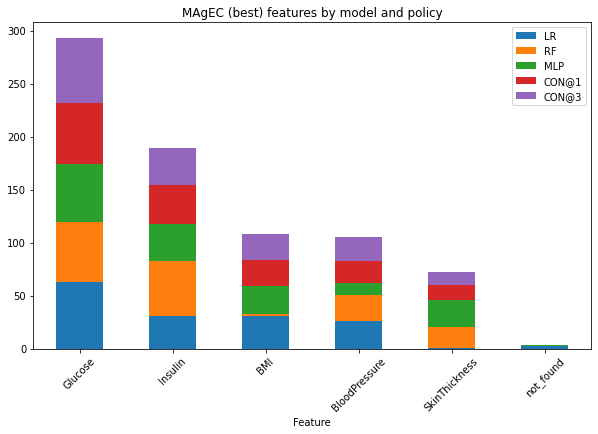

In [49]:
stats = ranked_stats(ranks1)
con1 = con_stats(consensus1a)
con3 = con_stats(consensus3a, label='CON@3')
dfplot = df_stats(stats, con1, con3)
plot_stats(dfplot, True)

## MAgEC individual 'case'

In [50]:
case = 47

In [51]:
ranks1[ranks1['case'] == case].iloc[0]

case                                    47
timepoint                                0
Outcome                                  1
mlp_magec                        -0.390399
mlp_feat                           Glucose
rf_magec                         -0.589986
rf_feat                            Glucose
lr_magec                         -0.648005
lr_feat                            Glucose
perturb_BloodPressure_prob_mlp    0.364767
perturb_BloodPressure_prob_rf     0.510444
perturb_BloodPressure_prob_lr     0.319419
perturb_BMI_prob_mlp              0.350264
perturb_BMI_prob_rf                0.51027
perturb_BMI_prob_lr               0.297848
perturb_Glucose_prob_mlp          0.198182
perturb_Glucose_prob_rf           0.419034
perturb_Glucose_prob_lr           0.148306
perturb_Insulin_prob_mlp          0.203511
perturb_Insulin_prob_rf           0.424247
perturb_Insulin_prob_lr           0.372988
perturb_SkinThickness_prob_mlp    0.312871
perturb_SkinThickness_prob_rf     0.509521
perturb_Ski

In [52]:
ranks3[ranks3['case'] == case].iloc[0]

case                                         47
timepoint                                     0
Outcome                                       1
mlp_magec_3                         -0.00700463
mlp_feat_3                        SkinThickness
mlp_magec_2                           -0.369564
mlp_feat_2                              Insulin
mlp_magec_1                           -0.390399
mlp_feat_1                              Glucose
rf_magec_3                           -0.0986526
rf_feat_3                         SkinThickness
rf_magec_2                            -0.561197
rf_feat_2                               Insulin
rf_magec_1                            -0.589986
rf_feat_1                               Glucose
lr_magec_3                                  NaN
lr_feat_3                             not_found
lr_magec_2                          -0.00684746
lr_feat_2                         SkinThickness
lr_magec_1                            -0.648005
lr_feat_1                               

In [53]:
consensus1a[consensus1a['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Glucose,1.382857,3,"[lr, mlp, rf]",33.749634,33.749634


In [54]:
consensus1b[consensus1b['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Glucose,0.460952,3,"[lr, mlp, rf]",33.749634,33.749634


In [55]:
consensus3a[consensus3a['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Glucose,1.382857,3,"[lr, mlp, rf]",33.749634,33.749634


In [56]:
consensus3b[consensus3b['case'] == case]

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
47,47,0,Glucose,0.460952,3,"[lr, mlp, rf]",33.749634,33.749634


### MAgEC correlations

In [57]:
corr = joined[joined.columns[2:]].corr()

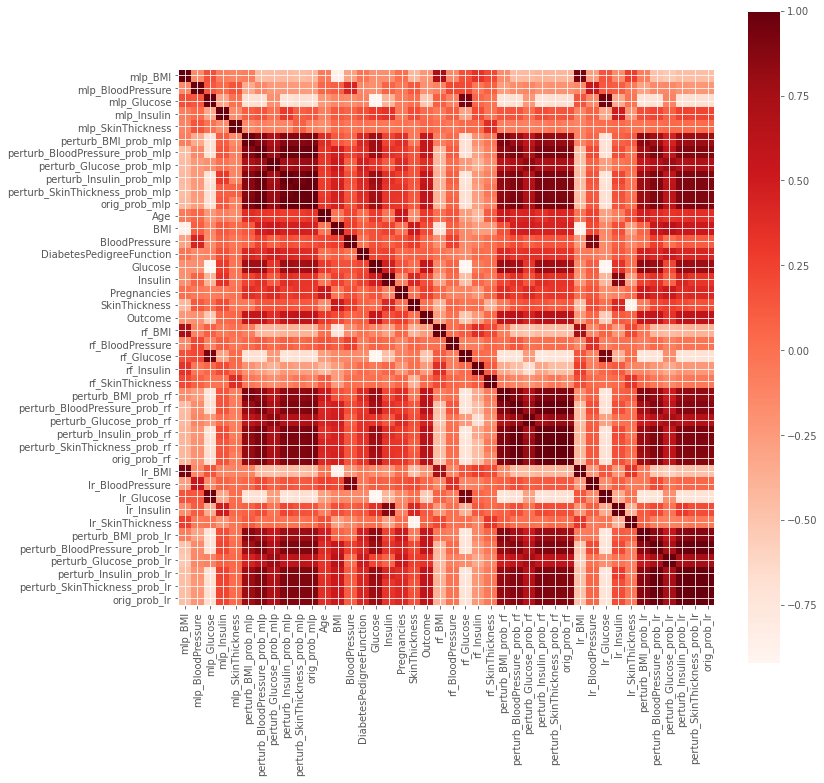

In [58]:
plt.figure(figsize=[12,12])
plt.style.use('ggplot')
plt.imshow(corr, cmap=plt.cm.Reds, interpolation='nearest')
plt.colorbar()
tick_marks = [i for i in range(len(joined.columns[2:]))]
plt.xticks(tick_marks, joined.columns[2:], rotation='vertical')
plt.yticks(tick_marks, joined.columns[2:]);

## MAgECs population similarity

In [59]:
sim_mlp = mg.magec_similarity(magecs_mlp, x_validation_p, model_name='mlp')
sim_rf = mg.magec_similarity(magecs_rf, x_validation_p, model_name='rf')
sim_lr = mg.magec_similarity(magecs_lr, x_validation_p, model_name='lr')

In [60]:
print("Top Absolute Correlationsin in MLP model")
print(mg.get_top_abs_correlations(sim_mlp, 10))

Top Absolute Correlationsin in MLP model
mlp_Glucose                   Glucose                     0.919489
mlp_BMI                       BMI                         0.853849
mlp_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.715581
Glucose                       Outcome                     0.544038
mlp_Glucose                   Outcome                     0.528077
BMI                           SkinThickness               0.509936
Glucose                       Insulin                     0.470695
mlp_BloodPressure             BloodPressure               0.433069
mlp_BMI                       SkinThickness               0.422696
Insulin                       SkinThickness               0.407630
dtype: float64


In [61]:
print("Top Absolute Correlationsin in RF model")
print(mg.get_top_abs_correlations(sim_rf, 5))

Top Absolute Correlationsin in RF model
rf_Glucose                   Glucose                     0.921324
rf_BMI                       BMI                         0.732446
rf_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.614214
Glucose                      Outcome                     0.544038
BMI                          SkinThickness               0.509936
dtype: float64


In [62]:
print("Top Absolute Correlationsin LR model")
print(mg.get_top_abs_correlations(sim_lr, 5))

Top Absolute Correlationsin LR model
lr_Glucose                   Glucose                     0.921184
lr_BloodPressure             BloodPressure               0.895361
lr_DiabetesPedigreeFunction  DiabetesPedigreeFunction    0.892023
lr_SkinThickness             SkinThickness               0.871342
lr_BMI                       BMI                         0.871290
dtype: float64


### PIMA Exploratory Data Analysis (EDA)

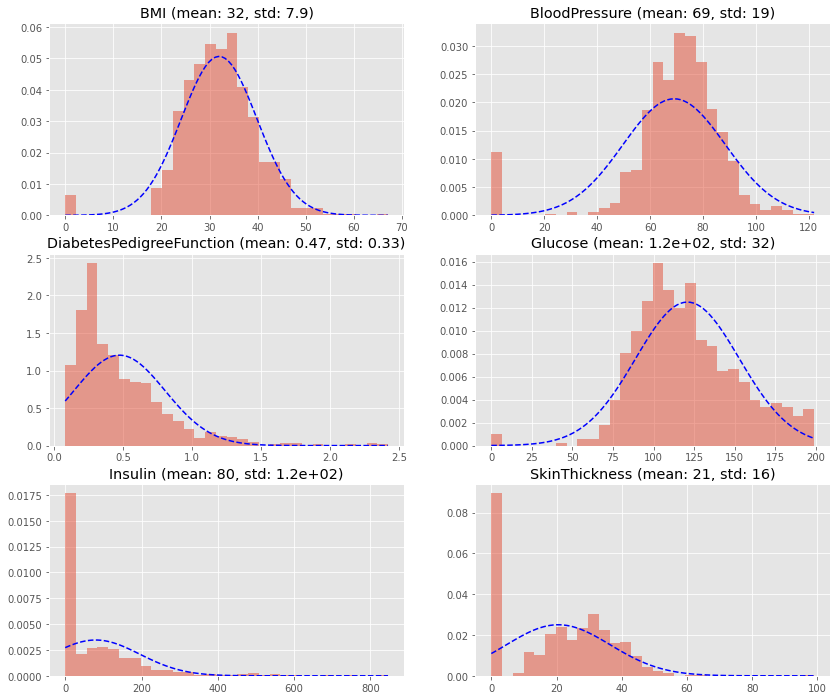

In [63]:
mg.plot_pima_features(pima);

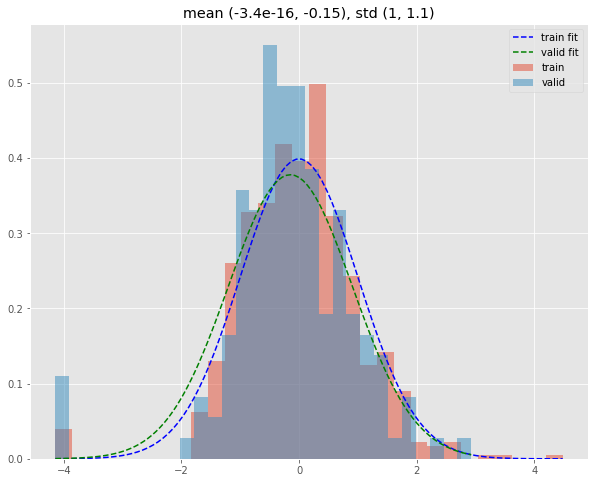

In [64]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BMI')

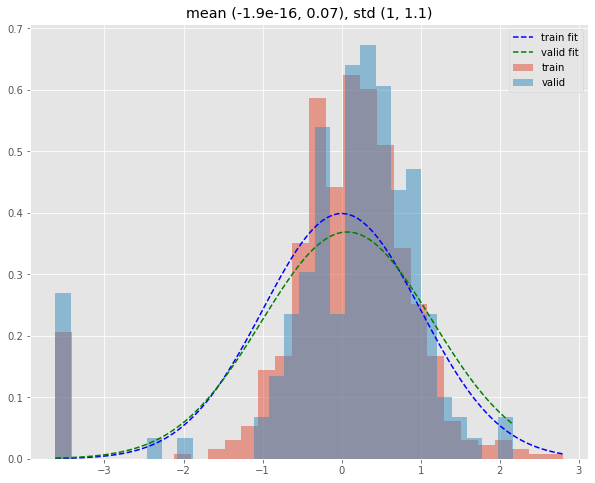

In [65]:
mg.plot_train_valid(x_train_p, x_validation_p, 'BloodPressure')

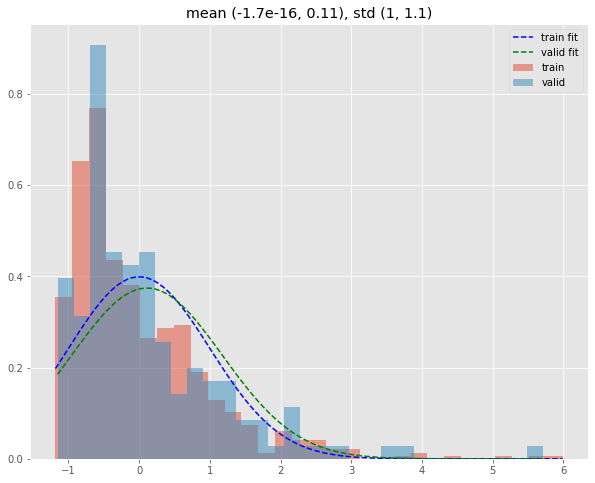

In [66]:
mg.plot_train_valid(x_train_p, x_validation_p, 'DiabetesPedigreeFunction')

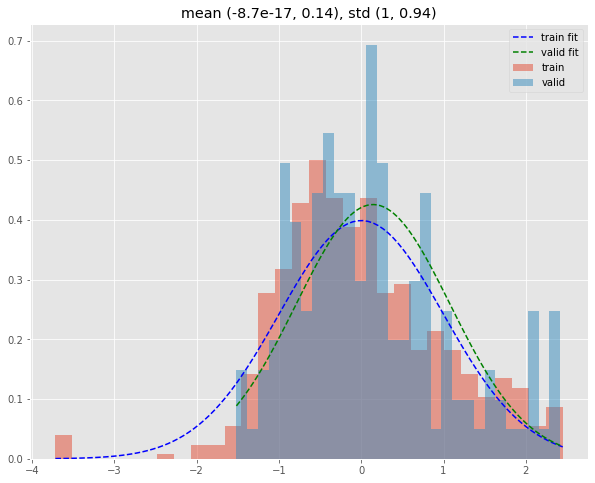

In [67]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Glucose')

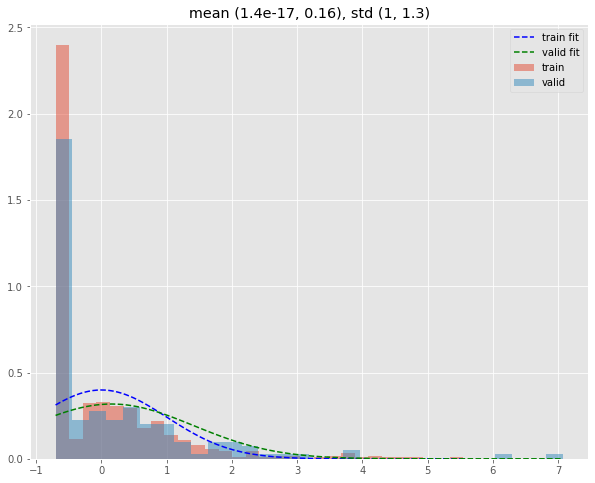

In [68]:
mg.plot_train_valid(x_train_p, x_validation_p, 'Insulin')

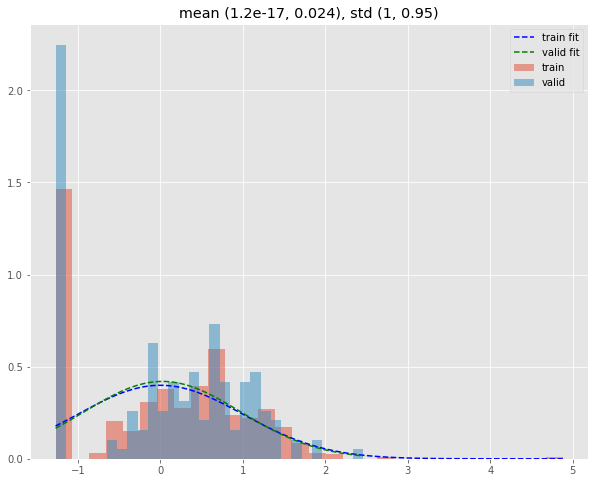

In [69]:
mg.plot_train_valid(x_train_p, x_validation_p, 'SkinThickness')